# SigmaBAM Chemical Inventory - Excel to openBIS Adapter

## Goal
This script converts a chemical inventory exported from **SigmaBAM** into a format compatible with **OpenBIS** batch upload via Excel. It ensures that chemical records follow OpenBIS structure and formatting, allowing efficient registration and future batch updates. Three Excel files are generated and saved locally:

Register file: for uploading new chemicals to openBIS (always register before updating)

Update file: for updating existing chemical entries

Debug file: for verifying if the concentration column was added correctly

---

## Instructions

### 1. **Export Your Excel File**
- WARNING: The SigmaBAM software and browser give different entries when exported as Excel files. The software provides more data (some columns are hidden from the online infoportal). Please use the software to export the data.
- Click the 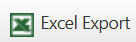 icon to upload the file.
- Ensure the file is clean (no merged cells, consistent headers).

### 2. **In openBIS**
- Navigate to:  
  `Inventory > Materials`
  
- Create a new **Project** and a new **collection** to store your chemicals (if not done already). Take notes of the space code, project code, collection code or name as it will be used to register and update the chemicals in the correct place. Warning: the codes can differ from the names.

### 3. **Run This Notebook**
- Connect yourself to openBIS using a PAT or by typing your password, check the url variable to make sure you are on the right instance (training instance 'https://training.datastore.bam.de/' for testing purpose or main instance 'https://main.datastore.bam.de/') (url)
- Find the collection you want to upload the chemicals in:
- Run this notebook and select the appropriate collection by choosing space, project, and collection indexes
- Modify the path to point to the exported Excel file (the excel file generated by SigmaBAM, see step 1) (source_path)
- Choose the responsible person source from SigmaBAM, either "AntragstellerIn" or "Gefahrstoffkoordinator*in" (responsible_source)
- (optional) Modify the generated excel file name, default name: "UPDATE_CHEMICALS_YYYY_MM_DD.xlsx" (update_output)
- (optional) Modify the generated debug excel file name, default name: "DEBUG_CHEMICALS_YYYY_MM_DD.xlsx" (debug_output)
- (optional) Modify the generated register excel file name, default name: "REGISTER_CHEMICALS_YYYY_MM_DD.xlsx" (debug_output)
- The script will:
  - Map the column names to openBIS-compatible property codes
  - Format the data properly
  - Output 3 final Excel files: register file, update file, debug file

### 4. **Upload and update OpenBIS**
- In OpenBIS, go to the right collection
- Click `More > XLS Batch Register Objects`
- Select the register Excel file.
- The chemicals will be imported in bulk into the selected collection.

- Click `More > XLS Batch Update Objects`
- Select the update Excel file.
- The chemicals will be imported in bulk into the selected collection.

### 5. **Add GHS pictograms as datasets** (optional)

- Download the pictogram images locally
- Modify the path to point to the file that contains the images (local_ghs_folder)
- Run the 2 last cells of the notebook to add a picture of the Globally Harmonized System of Classification and Labelling of Chemicals (GHS) pictograms as datasets for all registered chemicals in the collection you selected during step 3. The images will be saved as raw data. The script is checking if the pictograms have already been added, you can run the script multiple time without creating duplicates.

---

## Notes
In case the import doesn't work properly:
- Make sure you have the necessary **permissions** in openBIS.
- Check if any **controlled vocabulary** fields need to match specific terms.
  
- The column "description" is empty, you can add whatever extra information that is not on the system.
- The script is modular and can be adapted to other formats if needed.

- 'Code' and 'Identifier' columns:
    We use a 'Code' format like "CHEM-X.Y-ZZZZ" where:
    - "CHEM" indicates chemical
    - "X.Y" represents your division
    - "ZZZZ" (last 4 digits) store the Umgang-Id from the SigmaBAM Excel file
    These codes form stable unique keys linking SigmaBAM records to openBIS, essential for updates.

    IMPORTANT:
    - After upload, these codes must remain unchanged.
    - Users can customize the Code string format before generating the file, but should keep the Umgang-Id at the end intact.
    This ensures consistency between SigmaBAM and openBIS systems.

---

## Resources
openBIS XLS Batch Upload Documentation:
https://openbis.readthedocs.io/en/20.10.x/user-documentation/general-users/inventory-of-materials-and-methods.html#batch-register-entries-in-a-collection

## Contact
For help, comments or improvements, reach out to: https://github.com/TomCharlesRousseau

---

## Version
version 1.0

# Connect yourself to OpenBIS

In [1]:
from pybis import Openbis
# url = 'https://main.datastore.bam.de/'
url = 'https://training.datastore.bam.de/'
pat = '' # leave empty to read token from file or authenticate with username
userid = '' # leave empty to use the username from your local machine
space  = '' # leave empty to use the users home space

try:
    from os import environ
    pat = pat or open(environ.get('OPENBIS_PAT_FILE', 'OPENBIS_PAT.txt'), 'r').read().strip()
    o = Openbis(url, token=pat)
    userid = o.token.split('-')[1]
except:
    from getpass import getuser, getpass
    o = Openbis(url)
    userid = userid.lower() or getuser()
    password = getpass('Enter password for user {} at {}: '.format(userid, url))
    o.login(userid, password)
server_info = o.get_server_information()
person = o.get_person(userid)
space = space.upper() or person.space

print('Server: {} (openBIS {}, API {})'.format(o.hostname, server_info.openbis_version, server_info.api_version))
print('UserId: {} ({} {}, {})'.format(person.userId, person.firstName, person.lastName, person.email))
print('Space : {}'.format(space))

Enter password for user troussea at https://training.datastore.bam.de/:  ········


Server: training.datastore.bam.de (openBIS 20.10.11.1, API 3.7)
UserId: troussea (Tom Rousseau, tom.rousseau@bam.de)
Space : X.1_TROUSSEA


# Manual Collection Creation Reminder

Please create the collection manually in your division's inventory space under the specific project.

Note that the collection is identified by its code, which may differ from its display name. Currently, collection names cannot be set or modified via pybis—they can only be managed directly in openBIS. This is why manual creation of the collection is recommended.

The script below helps you verify the existence of the desired collection. When running it, select the index corresponding to the Space where your collection resides, then choose the Project, and finally the Collection itself.

This selected collection will later be used to generate an "Identifier" for your samples, enabling batch updates in openBIS via the Batch Update function.

In [2]:
def choose_from_list(items, prompt):
    while True:
        try:
            idx = int(input(prompt))
            if 0 <= idx < len(items):
                return items[idx]
            else:
                logging.warning(f"Input out of range: {idx}")
                print(f"Please enter a number between 0 and {len(items)-1}")
        except ValueError:
            logging.warning("Invalid input: not an integer")
            print("Please enter a valid integer.")


# Show available spaces (code), prompt the user to input the index number of the desired space
spaces = o.get_spaces()
print("Available spaces:")
for i, s in enumerate(spaces):
    print(f"{i}: {s.code}")
space = choose_from_list(spaces, "Select a space by index: ")

# Show available project (code) within the selected space, prompt the user to input the index number of the desired project
projects = o.get_projects(space=space.code)
print(f"Projects in space {space.code}:")
for i, p in enumerate(projects):
    print(f"{i}: {p.code}")
project = choose_from_list(projects, "Select a project by index: ")

# Show available collection (code and name) within the selected project, prompt the user to input the index number of the desired collection
collections = [c for c in o.get_experiments(space=space.code, project=project.code) if c.type == "COLLECTION"]
print(f"Collections in {space.code}/{project.code}:")
for i, c in enumerate(collections):
    print(f"{i}: {c.code}, Name: {c.props.get('$name')}")
collection = choose_from_list(collections, "Select a collection by index: ")
print("\n")
print("-" * 100)
print("\nSelected:")
print(f"Space Code: {space.code}")
print(f"Project Code: {project.code}")
print(f"Collection Code: {collection.code}, Collection Name: {collection.props.get('$name')}")
print("\n")
print("-" * 100)
print("\nSample path prefix:")
sample_path_openbis_prefix = f"/{space.code}/{project.code}/{collection.code}/"
print(sample_path_openbis_prefix)
print("\n")
print("-" * 100)
print("\nIdentifier prefix:")
identifier_prefix =f"/{space.code}/{project.code}/"
print(identifier_prefix)

Available spaces:
0: ELN_SETTINGS
1: X.1_ELN_SETTINGS
2: X.1_EQUIPMENT
3: X.1_MATERIALS
4: X.1_METHODS
5: X.1_PUBLICATIONS
6: X.1_STORAGE
7: X.1_ABAMUSER
8: X.1_EBAMUSER
9: X.1_MBAMUSER
10: X.1_PBAMUSER
11: BAM_EQUIPMENT
12: BAM_MATERIALS
13: BAM_METHODS
14: BAM_PUBLICATIONS
15: BAM_GLOBAL
16: 00_DEMO
17: X.1_ASCHELLE
18: X.1_BMIELLER
19: X.1_CDEMIDOV
20: X.1_DMCMAHON
21: X.1_EESCHE
22: X.1_GESPINOZ
23: X.1_HKUNTE
24: X.1_JGUENSTE
25: X.1_JRAEDLER
26: X.1_JSCHUMAC
27: X.1_JSONG1
28: X.1_KSCHWIBB
29: X.1_LSCHEFFO
30: X.1_RBANASIA
31: X.1_SOBERBEC
32: X.1_TROUSSEA
33: X.1_BMARTENS
34: X.1_HBRESCH
35: X.1_LPYZA
36: X.1_MHIRSCHV
37: X.1_MJULSETH


Select a space by index:  3


Projects in space X.1_MATERIALS:
0: PROJECT_CONSUMABLES
1: DEMOS
2: CONSUMABLES


Select a project by index:  2


Collections in X.1_MATERIALS/CONSUMABLES:
0: CONSUMABLES_EXP_2, Name: Sample
1: BATCH_REGISTRATION_STORAGE_2, Name: TOM STORAGE
2: KITS, Name: Kit
3: CONSUMABLES_EXP_3, Name: Test_Batch_registration_storage
4: CONSUMABLES_EXP_4, Name: Test_Chemicals_with_responsible_person
5: CONSUMABLES_PICTOGRAMS, Name: Pictograms
6: CONSUMABLES_EXP_1, Name: Chemicals
7: BATCH_REGISTRATION_STORAGE, Name: CHEMICALS_REGIST


Select a collection by index:  1




----------------------------------------------------------------------------------------------------

Selected:
Space Code: X.1_MATERIALS
Project Code: CONSUMABLES
Collection Code: BATCH_REGISTRATION_STORAGE_2, Collection Name: TOM STORAGE


----------------------------------------------------------------------------------------------------

Sample path prefix:
/X.1_MATERIALS/CONSUMABLES/BATCH_REGISTRATION_STORAGE_2/


----------------------------------------------------------------------------------------------------

Identifier prefix:
/X.1_MATERIALS/CONSUMABLES/


# Generate openBIS readable excel

# Imports and global variables

In [3]:
from datetime import datetime
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import Font, PatternFill
import re
import os
import logging
import shutil

# Variable to be changed

Manually select the Excel source file generated by SigmaBAM

In [5]:
import tkinter as tk
from tkinter import filedialog
from pathlib import Path

# Hide the main Tkinter window
root = tk.Tk()
root.withdraw()

# Ask the user to select a file
file_path = filedialog.askopenfilename(
    title="Select Excel source file generated by SigmaBAM",
    filetypes=[("Excel files", "*.xlsx *.xls")]
)

if file_path:
    source_path = Path(file_path)
    print(f"Selected file: {source_path}")
else:
    print("No file selected.")

Selected file: C:\Users\troussea\Downloads\2025-06-20_Chemicals_TESTFORAPI.xlsx


If not working copy paste the path of the source file and uncomment the following line

In [ ]:
#source_path = r""  # Input file (source excel file generated from SigmaBAM)

In [6]:
# Output Paths
today = datetime.today().strftime("%Y_%m_%d")
update_output = f"UPDATE_CHEMICALS_{today}.xlsx" # optional change
debug_output = f"DEBUG_CHEMICALS_{today}.xlsx" # optional change
register_output = f"REGISTER_CHEMICALS_{today}.xlsx" # optional change

# Choose the responsible person source from SigmaBAM (comment the other line with # symbol) either "AntragstellerIn" or "Gefahrstoffkoordinator*in" 
responsible_source = "AntragstellerIn"
# responsible_source = "Gefahrstoffkoordinator*in" 

In [7]:
# Column mapping
column_map = {
    "Handelsname": "Name",
    "Synonyme": "Alternative Name",
    "CAS-Nr": "CAS Registry Number",
    "Hersteller": "Manufacturer",
    "Konzentration [%]": "Concentration",
    "Dichte [g/cm\u00b3]": "Density",
}

# Division list
Division_list = [
    "1.1 Inorganic Trace Analysis",
    "1.2 Biophotonics",
    "1.3 Instrumental Analytics",
    "1.4 Process Analytical Technology",
    "1.5 Protein Analysis",
    "1.6 Inorganic Reference Materials",
    "1.7 Organic Trace and Food Analysis",
    "1.8 Environmental Analysis",
    "1.9 Chemical and Optical Sensing",
    "2.1 Safety of Energy Carriers",
    "2.2 Process Simulation",
    "2.3 Classification of Hazardous Substances and Dangerous Goods",
    "2.4 Testing and Evaluation of Explosives and Pyrotechnics",
    "2.5 Conformity Assessment Explosives and Pyrotechnics",
    "3.1 Safety of Dangerous Goods Packagings and Batteries",
    "3.2 Safety of Energy Storage Systems",
    "3.3 Safety of Transport Containers",
    "3.4 Safety of Storage Containers",
    "3.5 Safety of Gas Storage Systems and Tanks For Dangerous Goods",
    "3.6 Electrochemical Energy Materials",
    "4.1 Biodeterioration and Reference Organisms",
    "4.2 Material-Microbiome Interactions",
    "4.3 Molecular and Applied Entomology",
    "4.4 Thermochemical Residues Treatment and Resource Recovery",
    "4.5 Analysis of Artefacts and Cultural Assets",
    "5.1 Microstructural Design and Degradation",
    "5.2 Metallic High-Temperature Materials",
    "5.3 Polymer Matrix Composites",
    "5.4 Advanced Multi-materials Processing",
    "5.5 Materials Modelling",
    "5.6 Glasses",
    "6.1 Surface and Thin Film Analysis",
    "6.2 Material and Surface Technologies",
    "6.3 Structure Analysis",
    "6.4 Materials Informatics",
    "6.5 Synthesis and Scattering of Nanostructured Materials",
    "6.6 Digital Materials Chemistry",
    "6.7 Materials Synthesis and Design",
    "7.1 Building Materials",
    "7.2 Buildings and Structures",
    "7.3 Fire Engineering",
    "7.4 Technology of Construction Materials",
    "7.5 Technical Properties of Polymeric Materials",
    "7.6 Corrosion and Corrosion Protection",
    "7.7 Modelling and Simulation",
    "8.1 Sensors, Measurement and Testing Methods",
    "8.2 Non-Destructive Testing Methods For Civil Engineering",
    "8.3 Thermographic Methods",
    "8.4 Acoustic and Electromagnetic Methods",
    "8.5 X-Ray Imaging",
    "8.6 Fibre Optic Sensors",
    "9.1 Components For Energy Carriers",
    "9.2 Testing Devices and Equipment",
    "9.3 Welding Technology",
    "9.4 Weld Mechanics",
    "9.5 Tribology and Wear Protection",
    "9.6 Additive Manufacturing of Metallic Components",
    "S.1 Quality In Testing",
    "S.2 Digitalization of Quality Infrastructure",
    "S.3 Ecodesign and Energy Labelling",
    "Z.1 Organisation, Controlling",
    "Z.2 Budget",
    "Z.3 Human Resources",
    "Z.4 Education and Training, Health Management",
    "Z.5 Procurement",
    "Z.6 Internal Services",
    "Z.7 Buildings",
    "Z.8 Legal Services office, Library",
    "Z.9 Research Services"
]

# Notes content
note_cols = ["Piktogramme", "Reinheit", "Druck [Bar]", "max. Menge", "Konzentration [%]", "CMR", "H-Sätze", "EUH-Sätze", "P-Sätze"]

# Product Category from openBIS
allowed_pc_codes = {"PC0", "PC1", "PC2", "PC3", "PC4", "PC7", "PC8", "PC9A", "PC9B", "PC9C",
    "PC11", "PC12", "PC13", "PC14", "PC15", "PC16", "PC17", "PC18", "PC20", "PC21",
    "PC23", "PC24", "PC25", "PC26", "PC27", "PC28", "PC29", "PC30", "PC31", "PC32",
    "PC33", "PC34", "PC35", "PC36", "PC37", "PC38", "PC39", "PC40", "PC41", "PC42"}

# Utility functions

In [8]:
def get_bam_path(name):
    """Convert a person's full name into a BAM path format."""
    if not isinstance(name, str) or name.strip() == "":
        return None
    replacements = {'ä': 'ae', 'ö': 'oe', 'ü': 'ue', 'Ä': 'Ae', 'Ö': 'Oe', 'Ü': 'Ue'}
    for orig, repl in replacements.items():
        name = name.replace(orig, repl)
    parts = name.strip().split()
    if len(parts) < 2:
        return None
    first_letter = parts[-1][0].upper()
    last_part = parts[0][:7].upper()
    return f"/BAM_GLOBAL/BAM_DATA/{first_letter}{last_part}"

def get_division_name(code: str) -> str:
    """Return the full division name given its numeric code (e.g. '1.1')."""
    for item in Division_list :
        if item.startswith(code + " "):
            return item
    return "Division not found"

def clean_concentration_with_log(val):
    """
    Clean a concentration value (as string), remove symbols (<, >, %, etc.),
    convert it to float, and return a validation log message.
    """
    if not isinstance(val, str):
        return (None, "Invalid: not a string")

    original = val.strip()
    val = original.replace('%', '').replace('<', '').replace('>', '')

    if '-' in val:
        return (0.0, f"Range detected in '{original}' → set to 0")

    match = re.search(r'[\d.,]+', val)
    if match:
        num = match.group().replace(',', '.')
        try:
            return (float(num), None)
        except:
            return (None, f"Invalid number in '{original}'")

    return (None, f"Unrecognized format: '{original}'")

def build_notes(row):
    """
    Build 'Notes' by concatenating values from specific columns.
    Empty cells are replaced with 'None'.
    """
    return " | ".join(
        f"{col}: {row[col] if pd.notna(row[col]) and str(row[col]).strip() else 'None'}"
        for col in note_cols
        if col in row
    )

def extract_pc_code(cat):
    """
    Extract the product category code (e.g. 'PC1') from a string.
    Return it only if it is in the list of allowed codes.
    """
    if not isinstance(cat, str):
        return None
    code = cat.split()[0]
    return code if code in allowed_pc_codes else None

def concat_location(row):
    """
    Concatenate the BAM location columns into a single formatted string.
    Format: Liegenschaft/Haus/Etage/Raum-Nr
    """
    location_cols = ["Liegenschaft", "Haus", "Etage", "Raum-Nr"]
    return "/".join(str(row[col]).strip() for col in location_cols if pd.notna(row.get(col)) and str(row[col]).strip())

def generate_code(row):
    """
    Generate a unique code in the format 'CHEM-<Organisationseinheit>-<Umgang-Id>',
    with Umgang-Id zero-padded to 4 digits.
    """
    entity = row["Organisationseinheit"]
    umgang_id = str(row["Umgang-Id"]).zfill(4)
    if pd.isna(entity) or pd.isna(umgang_id):
        return None
    return f"CHEM-{entity}-{umgang_id}"

# Data loading & pre-processing

In [9]:
# Load the source Excel file
df_source = pd.read_excel(source_path, header=0, engine='openpyxl', dtype=str)

# Create an empty final DataFrame
df_final = pd.DataFrame()

# Add the '$' column by prefixing 'Umgang-Id' with a dollar sign.
# This will be used to generate the sample code and link samples between SigmaBAM and openBIS.
df_final['$'] = df_source['Umgang-Id'].apply(lambda x: f"${x}")

# Apply column mapping from source to final DataFrame
for source_col, final_col in column_map.items():
    df_final[final_col] = df_source.get(source_col, None)

# Apply 'Responsible person' column using get_bam_path if the source column exists
if responsible_source in df_source.columns:
    df_final["Responsible person"] = df_source[responsible_source].apply(get_bam_path)
else:
    df_final["Responsible person"] = None

# Apply 'BAM Organizational Entity' column using get_division_name if the source column exists
if "Organisationseinheit" in df_source.columns:
    df_final["BAM Organizational Entity"] = df_source["Organisationseinheit"].astype(str).apply(get_division_name)
else:
    df_final["BAM Organizational Entity"] = None

# Clean the 'Concentration' column and generate a validation log.
# The log records entries that can't be converted to valid numbers (required by openBIS).
# Only 'Concentration' is included in the final output; the 'Validation Log' is saved for debugging.
df_final[['Concentration', 'Validation Log']] = df_source["Konzentration [%]"].apply(clean_concentration_with_log).apply(pd.Series)

# Build the 'Notes' column by applying build_notes function row-wise
df_final["Notes"] = df_source.apply(build_notes, axis=1)

# Advanced mapping, calculated columns

In [10]:
# Mandatory column (None if missing)
final_columns = [
    '$', 'Name', 'Alternative Name', 'IUPAC Name', 'CAS Registry Number', 'Manufacturer',
    'Supplier', 'Lot/Batch Number', 'External Barcode', 'Description', 'Product Category',
    'Hazardous Substance', 'BAM Organizational Entity', 'Complete BAM Location',
    'Responsible person', 'Molar Mass', 'Density', 'Concentration',
    'Bottling Date', 'Opening Date', 'Expiration Date', 'Empty', 'Notes', 'Comments', 'Code', 'Identifier'
]

for col in final_columns:
    if col not in df_final.columns:
        df_final[col] = None

# Hazardous Substance booleans
hazard_cols = ["H-Sätze", "EUH-Sätze", "P-Sätze", "CMR"]
df_final["Hazardous Substance"] = df_source.apply(
    lambda row: "true" if any(pd.notna(row.get(col)) and str(row.get(col)).strip() != "" for col in hazard_cols) else "false",
    axis=1
)

# Product Category
if "Produktkategorie" in df_source.columns:
    df_final["Product Category"] = df_source["Produktkategorie"].apply(extract_pc_code)

# Complete BAM Location
df_final["Complete BAM Location"] = df_source.apply(concat_location, axis=1)

# Code and Identifier
df_final["Code"] = df_source.apply(generate_code, axis=1)
df_final['Identifier'] = identifier_prefix + df_final['Code'].astype(str)

# Excel output & formatting

## Debug file generation

In [11]:
# Ensure 'Validation Log' column exists in df_final for debug purposes
if "Validation Log" not in df_final.columns:
    df_final["Validation Log"] = None  # Add empty column if missing

# Save Excel file starting from row 4 (header offset)
df_final.to_excel(debug_output, index=False, startrow=3, engine='openpyxl')

# Modify header formatting and content
wb = load_workbook(debug_output)
ws = wb.active
ws["A1"] = "SAMPLE"
ws["A2"] = "Sample type"
ws["A3"] = "CHEMICAL"
ws["A3"].font = Font(bold=True)
ws["A1"].fill = PatternFill(start_color="FFA500", end_color="FFA500", fill_type="solid")
wb.save(debug_output)

logging.basicConfig(level=logging.INFO)

# Inform user that Validation Log column is included for concentration check
logging.info("Validation Log column added to help verify concentration formatting.")

print("-" * 100)
print(f"Debug file generated: {debug_output}")
print(f"Debug file path: {os.path.abspath(debug_output)}")

INFO:root:Validation Log column added to help verify concentration formatting.


----------------------------------------------------------------------------------------------------
Debug file generated: DEBUG_CHEMICALS_2025_08_13.xlsx
Debug file path: C:\Users\troussea\Documents\Code\Projects\ProjetopenBIS\Mapping\DEBUG_CHEMICALS_2025_08_13.xlsx


## Update file generation

In [12]:
# Remove 'Validation Log' column if it exists, ignore error if not present
df_final.drop(columns=["Validation Log"], inplace=True, errors='ignore')

# Save the dataframe to Excel starting from row 4 (header offset)
df_final.to_excel(update_output, index=False, startrow=3, engine='openpyxl')

# Modify Excel header cells and formatting
wb = load_workbook(update_output)
ws = wb.active
ws["A1"] = "SAMPLE"
ws["A2"] = "Sample type"
ws["A3"] = "CHEMICAL"
ws["A3"].font = Font(bold=True)
ws["A1"].fill = PatternFill(start_color="FFA500", end_color="FFA500", fill_type="solid")

# Save changes to the Excel file
wb.save(update_output)

# Inform user about the generated debug file location
print(f"Update file generated: {update_output}")
print(f"Update file path: {os.path.abspath(update_output)}")

Update file generated: UPDATE_CHEMICALS_2025_08_13.xlsx
Update file path: C:\Users\troussea\Documents\Code\Projects\ProjetopenBIS\Mapping\UPDATE_CHEMICALS_2025_08_13.xlsx


## Register file generation

In [16]:
# Get all sample identifiers from this collection
samples = o.get_samples(space=space.code, project=project.code, collection=collection.code)
openbis_ids = [s.identifier for s in samples]

# Load Excel
df_source = pd.read_excel(update_output, header=3, engine="openpyxl", dtype=str)

# Get identifiers from Excel
excel_ids = df_source["Identifier"].tolist()

# Compare lists
to_be_added_list = [i for i in excel_ids if i not in openbis_ids] # list of identifiers that exists in the Excel but not in openBIS
if len(to_be_added_list) == 0:
    print("All identifier were already found in the selected collection")
else:
    print(to_be_added_list)
    print(f"{len(to_be_added_list)} identifiers missing in openBIS.")
    print(f"New samples {to_be_added_list}")

# Filter Excel and save
df_filtered = df_source[df_source["Identifier"].isin(to_be_added_list)]
today = datetime.today().strftime("%Y_%m_%d")
df_filtered.to_excel(register_output, index=False, startrow=3, engine="openpyxl")

# Modify Excel header cells and formatting
wb = load_workbook(register_output)
ws = wb.active
ws["A1"] = "SAMPLE"
ws["A2"] = "Sample type"
ws["A3"] = "CHEMICAL"
ws["A3"].font = Font(bold=True)
ws["A1"].fill = PatternFill(start_color="FFA500", end_color="FFA500", fill_type="solid")

# Save changes to the Excel file
wb.save(register_output)

if len(to_be_added_list) != 0:
    print(f"New samples added in the file saved as: {register_output}")

All identifier were found in the selected collection


# Add pictograms as clickable links to the notes

In [ ]:
# Removed from final version adding them in as dataset is enough See version 0.1 to see the code

# Add pictograms as dataset

Manually select the folder where you saved the pictograms

In [18]:
# Hide the main Tkinter window
root = tk.Tk()
root.withdraw()

# Ask the user to select a folder
folder_path = filedialog.askdirectory(
    title="Select pictogram folder"
)

if folder_path:
    local_ghs_folder = Path(folder_path)
    print(f"Selected folder: {local_ghs_folder}")
else:
    print("No folder selected.")


Selected folder: C:\Users\troussea\Documents\Code\Projects\ProjetopenBIS\Mapping\GHS Pictograms


if not working copy paste the path of the folder that contains the pictograms and uncomment the following line

In [ ]:
#local_ghs_folder = r""

In [20]:
# Local pictogram folder and mapping
ghs_filenames = {
    "GHS01": "GHS01 - explosive.png",
    "GHS02": "GHS02 - flammable.png",
    "GHS03": "GHS03 - oxidizing.png",
    "GHS04": "GHS04 - compressed gas.png",
    "GHS05": "GHS05 - corrosive.png",
    "GHS06": "GHS06 - toxic.png",
    "GHS07": "GHS07 - health hazard.png",
    "GHS08": "GHS08 - serious health hazard.png",
    "GHS09": "GHS09 - hazardous to the environment.png", 
}

In [21]:
def dataset_exists_with_name(sample, filename):
    datasets = o.get_datasets(sample=sample.permId)
    for ds in datasets:
        if ds.props.get("$name") == filename:
            return True
    return False

samples = o.get_samples(collection=collection.code)

added_any = False
for sample in samples:
    notes_content = sample.props["notes"].strip()
    found_codes = [code for code in ghs_filenames if code in notes_content]

    for code in found_codes:
        filename = ghs_filenames[code]
        file_path = os.path.join(local_ghs_folder, filename)

        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        if dataset_exists_with_name(sample, filename):
            print(f"Dataset with name='{filename}' already exists on sample {sample.code}, skipping.")
            continue

        dataset = o.new_dataset(
            type="RAW_DATA",
            files=[file_path],
            props={"$name": filename}
        )
        dataset.sample = sample

        if hasattr(sample, "experiment") and sample.experiment:
            dataset.experiment = sample.experiment
        else:
            raise ValueError(f"No experiment associated with sample {sample.code}")

        dataset.save()
        added_any = True
        print(f"Dataset created and attached with name '{filename}': {filename} -> {sample.code}")

if added_any:
    print("Pictograms have been added as datasets where missing.")
else:
    print("No new pictogram datasets were added because they were already present.")


Dataset with name='GHS01 - explosive.png' already exists on sample CHEM-5.4-0001, skipping.
Dataset with name='GHS04 - compressed gas.png' already exists on sample CHEM-5.4-0001, skipping.
Dataset with name='GHS08 - serious health hazard.png' already exists on sample CHEM-5.4-0001, skipping.
Dataset with name='GHS09 - hazardous to the environment.png' already exists on sample CHEM-5.4-0001, skipping.
Dataset with name='GHS04 - compressed gas.png' already exists on sample CHEM-5.4-0002, skipping.
Dataset with name='GHS04 - compressed gas.png' already exists on sample CHEM-5.4-0003, skipping.
Dataset with name='GHS07 - health hazard.png' already exists on sample CHEM-5.4-0004, skipping.
Dataset with name='GHS07 - health hazard.png' already exists on sample CHEM-5.4-0013, skipping.
Dataset with name='GHS02 - flammable.png' already exists on sample CHEM-5.4-0014, skipping.
Dataset with name='GHS03 - oxidizing.png' already exists on sample CHEM-5.4-0014, skipping.
Dataset with name='GHS04 -